# Clasificación con técnica k-Nearest Neighbors (kNN)

## 1.1 Fundamentos de la técnica

El clasificador k-Nearest Neighbors (kNN) es un método de **aprendizaje supervisado**. Se utiliza tanto para tareas de clasificación como de regresión.

Su principio fundamental es que "instancias similares tienen etiquetas similares". Cuando se quiere clasificar una nueva muestra, el algoritmo observa las etiquetas de sus k vecinos más cercanos (los puntos de datos más similares) en el conjunto de entrenamiento. La nueva muestra se asigna a la clase más común entre esos k vecinos.

kNN es un método **no paramétrico**. Esto significa que:

- No hace suposiciones previas sobre la estructura del modelo (ej. no asume que los datos siguen una línea).
- El modelo se construye directamente a partir de los datos.
- Almacena todos los datos de entrenamiento, lo que se conoce como un método "basado en instancias" o "lazy learner".

## 1.2 Modelo matemático de la técnica

La formalización de kNN se centra en encontrar los vecinos más cercanos y realizar una "votación".

Dado un conjunto de entrenamiento $\mathcal{D}=\{(x_{i},y_{i})\}_{i=1}^{n}$, donde $x_i$ es el vector de características y $y_i$ es la etiqueta de clase para la $i$-éstima instancia.

Cuando queremos predecir la clase $\hat{y}$ de un nuevo punto $x$, la fórmula es:
$$\hat{y} = modo(\{y_{i} : x_{i} \in \mathcal{N}_{k}(x)\})$$

Donde:
- $\mathcal{N}_{k}(x)$ es el conjunto de los k vecinos más cercanos a $x$ que se encuentran en el conjunto de entrenamiento $\mathcal{D}$.
- $\{y_{i} : x_{i} \in \mathcal{N}_{k}(x)\}$ es el conjunto de las etiquetas de esos k vecinos.
- $modo( ... )$ es la función de moda, que devuelve la etiqueta (clase) más frecuente en ese conjunto.

Por ejemplo, si $k=5$ y las etiquetas de los 5 vecinos más cercanos son $\{A, B, A, A, B\}$, la moda es $A$ (aparece 3 veces) y, por lo tanto, $\hat{y} = A$.

Para encontrar los "vecinos más cercanos", se usa una métrica de distancia. La más común es la Distancia Euclidiana:
$$d(x, x') = \sqrt{\sum_{j=1}^{d}(x_{j} - x'_{j})^{2}}$$

Donde $d$ es la dimensionalidad (número de características) del vector $x$.

## 1.3 Descripción de la librería, clases, funciones y sus parámetros (python) empleadas en cada código

Para esta implementación, usaremos el ecosistema estándar de Ciencia de Datos en Python.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Librerías Principales
- `pandas`: Para la manipulación y análisis de datos. Usaremos su estructura DataFrame para cargar y explorar el dataset.
- `numpy`: Para cómputo numérico, especialmente para manejar los arreglos (arrays) de datos.
- `matplotlib` y `seaborn`: Para la visualización de datos, crucial en la etapa de preprocesamiento (ej. el Gráfico de Dispersión).
- `scikit-learn (sklearn)`: La librería principal para Machine Learning en Python. De aquí usaremos:
  - `datasets.load_iris`: Función para cargar el dataset de ejemplo.
  - `model_selection.train_test_split`: Función para dividir nuestro dataset en conjuntos de entrenamiento y prueba.
  - `preprocessing.StandardScaler`: Clase para realizar la normalización (estandarización Z-score) de los datos. Esto es vital en kNN, ya que se basa en distancias y las características deben tener escalas comparables.
  - `neighbors.KNeighborsClassifier`: La clase que implementa el algoritmo kNN.
    - `n_neighbors (k)`: El parámetro más importante. Define el número de vecinos ($k$) a considerar.
    - `metric`: La métrica de distancia a usar (por defecto 'minkowski', que con p=2 es la 'euclidean' 21).
  - `metrics`: Módulo que contiene las funciones para evaluar el modelo.
    - `confusion_matrix`, `accuracy_score`, `classification_report`.

## 1.4 Pipeline

In [2]:
# --- Carga de Datos ---
# Cargamos el dataset Iris
iris = load_iris()
# Creamos un DataFrame de pandas para facilitar la manipulación
# iris.data contiene las características, iris.feature_names los nombres de las columnas
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
# iris.target contiene las clases (0, 1, 2), iris.target_names los nombres de las clases
df['species'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Preprocess

Primero, realizamos un análisis estadístico básico y visualizamos los datos.

In [3]:
# --- Análisis Estadístico Previo ---
print("Información del DataFrame:")
df.info()

print("\nEstadísticas Descriptivas:")
print(df.describe())

print("\nConteo de clases (Species):")
print(df['species'].value_counts())

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB

Estadísticas Descriptivas:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   



Generando Gráfico de Dispersión (Pairplot)...


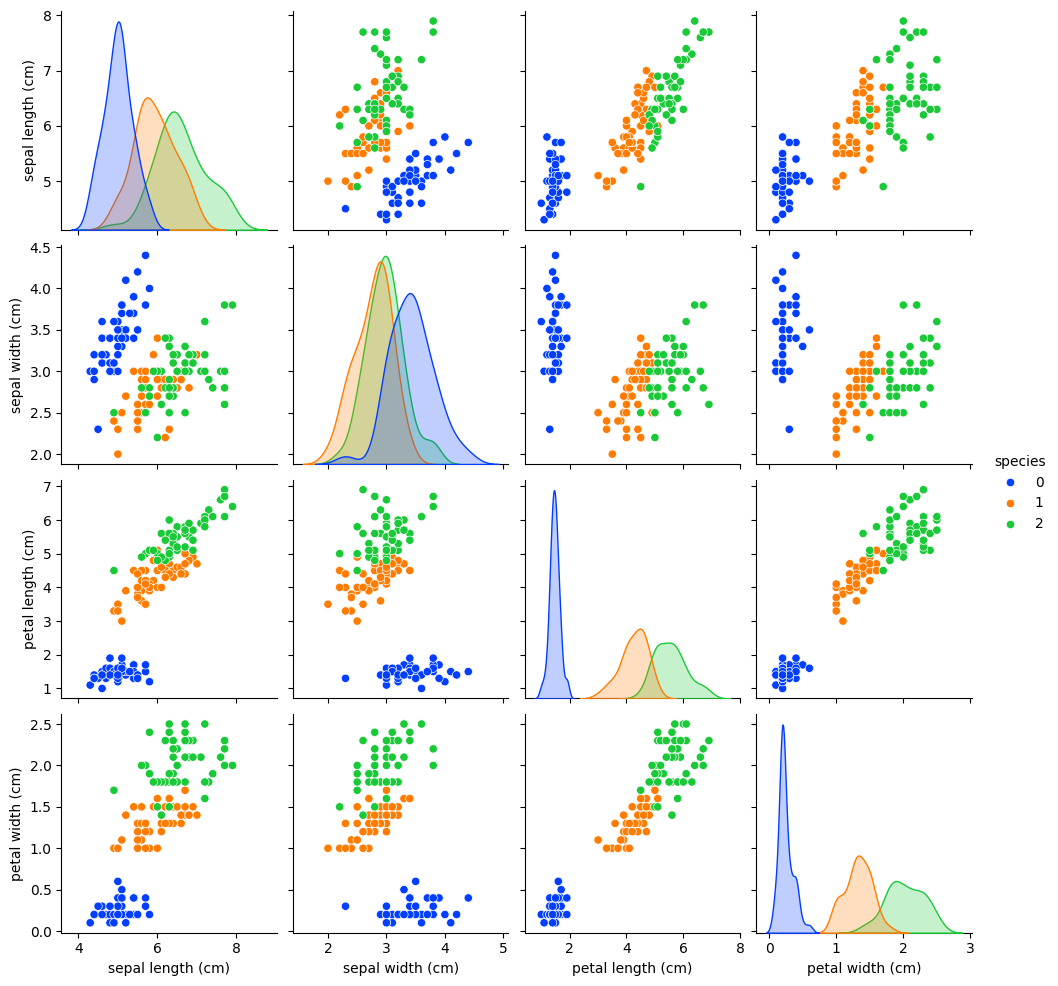

In [4]:
# --- Gráfico de Dispersión (Scatter Plot) ---
# Usamos pairplot de seaborn para visualizar las relaciones entre todas las características
# 'hue' colorea los puntos según la clase ('species')
print("\nGenerando Gráfico de Dispersión (Pairplot)...")
sns.pairplot(df, hue='species', palette='bright')
plt.show()

Observación del Gráfico: El pairplot nos muestra que las características petal length y petal width parecen ser muy buenas para separar las tres especies de flores.

**Normalización de Datos**

Como se mencionó en la teoría, kNN es sensible a las diferentes escalas de los datos. Si un atributo (ej. salario, 50000) tiene una escala mucho mayor que otro (ej. edad, 40), la distancia será dominada por el primer atributo.


Usaremos la Estandarización (Z-score), que transforma los datos para que tengan una media de 0 y una desviación estándar de 1.

$$x_{std} = \frac{x - \mu_{X}}{\sigma_{X}}$$

In [5]:
# Separamos las características (X) y la etiqueta (y)
X = df.drop('species', axis=1)
y = df['species']

# Dividimos los datos en entrenamiento (train) y prueba (test)
# 80% para entrenamiento, 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Normalización (StandardScaler) ---
# 1. Creamos el objeto escalador
scaler = StandardScaler()

# 2. Ajustamos el escalador SÓLO con los datos de entrenamiento (para evitar fuga de datos)
scaler.fit(X_train)

# 3. Transformamos ambos conjuntos (entrenamiento y prueba)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos de entrenamiento antes de escalar (primeras 5 filas):")
print(X_train.head())
print("\nDatos de entrenamiento después de escalar (primeras 5 filas):")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())

Datos de entrenamiento antes de escalar (primeras 5 filas):
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
8                  4.4               2.9                1.4               0.2
106                4.9               2.5                4.5               1.7
76                 6.8               2.8                4.8               1.4
9                  4.9               3.1                1.5               0.1
89                 5.5               2.5                4.0               1.3

Datos de entrenamiento después de escalar (primeras 5 filas):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0          -1.721568         -0.332101          -1.345722         -1.323276
1          -1.124492         -1.227655           0.414505          0.651763
2           1.144395         -0.555990           0.584850          0.256755
3          -1.124492          0.115676          -1.288941         -1.454945
4          -0.408002         

### Feature Engineering

En este caso, el dataset Iris tiene solo 4 características que, como vimos en el pairplot, son todas informativas. Para este modelo, emplearemos las 4 características (sepal length, sepal width, petal length, petal width).

En un problema más complejo, esta etapa implicaría:

- Analizar la correlación entre variables.
- Usar técnicas de selección de características (ej. Forward Selection, RFE) o extracción (ej. PCA) para reducir la dimensionalidad.

### Prediction

Primero, entrenamos el modelo kNN. Una elección común (y un buen punto de partida) para k es 5.

In [6]:
# --- Entrenamiento del Modelo kNN ---
# Instanciamos el clasificador con k=5
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)

# Entrenamos el modelo con los datos de entrenamiento escalados
knn_model.fit(X_train_scaled, y_train)

print(f"Modelo kNN (k={k}) entrenado exitosamente.")

Modelo kNN (k=5) entrenado exitosamente.


Ahora, creamos la función solicitada para clasificar un nuevo patrón.

In [7]:
def predecir_nueva_flor(patron, modelo, escalador, nombres_clases):
    """
    Clasifica un nuevo patrón (flor) usando el modelo kNN entrenado.

    Args:
    patron (np.array): Un array de 1D o 2D con las características
                       [sepal length, sepal width, petal length, petal width].
    modelo (KNeighborsClassifier): El modelo kNN ya entrenado.
    escalador (StandardScaler): El escalador ya ajustado con los datos de entreamiento.
    nombres_clases (list): Lista con los nombres de las clases (ej. ['Setosa', 'Versicolor', 'Virginica']).
    """
    # 1. Asegurarse que el patrón sea un array 2D (requerido por el scaler)
    if patron.ndim == 1:
        patron = patron.reshape(1, -1)

    # 2. Escalar el patrón usando el MISMO escalador del entrenamiento
    patron_scaled = escalador.transform(patron)

    # 3. Realizar la predicción
    pred_index = modelo.predict(patron_scaled)

    # 4. Obtener el nombre de la clase
    clase_predicha = nombres_clases[pred_index[0]]

    # (Opcional) Obtener las probabilidades (votos) de las k clases vecinas
    probabilidades = modelo.predict_proba(patron_scaled)

    print(f"--- Predicción para el patrón: {patron[0]} ---")
    print(f"Clase predecicha: {clase_predicha} (Índice {pred_index[0]})")
    print(f"Confianza (votos de vecinos): {np.max(probabilidades[0]):.2f}")

    return clase_predicha

# --- Prueba de la función ---
# Creemos un patrón de ejemplo (ej. una flor con medidas específicas)
# [sepal length, sepal width, petal length, petal width]
flor_nueva = np.array([5.1, 3.5, 1.4, 0.2]) # Estos son valores típicos de una 'Setosa'
flor_desconocida = np.array([6.0, 3.0, 4.8, 1.7]) # Valores intermedios

predecir_nueva_flor(flor_nueva, knn_model, scaler, iris.target_names);
print("\n")
predecir_nueva_flor(flor_desconocida, knn_model, scaler, iris.target_names);

--- Predicción para el patrón: [5.1 3.5 1.4 0.2] ---
Clase predecicha: setosa (Índice 0)
Confianza (votos de vecinos): 1.00


--- Predicción para el patrón: [6.  3.  4.8 1.7] ---
Clase predecicha: versicolor (Índice 1)
Confianza (votos de vecinos): 0.80


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Model Evaluation

Finalmente, evaluamos el rendimiento del modelo usando el conjunto de prueba (`X_test_scaled` y `y_test`) que el modelo nunca vio durante el entrenamiento.

--- Matriz de Confusión ---


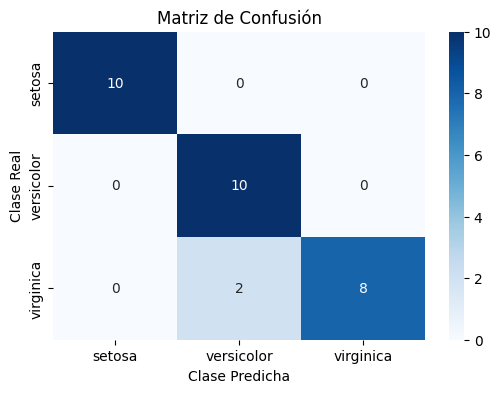


--- Accuracy (Exactitud) ---
El accuracy del modelo es: 0.9333 (o 93.33%)

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [8]:
# 1. Generar predicciones para el conjunto de prueba
y_pred = knn_model.predict(X_test_scaled)

# 2. Generar y mostrar la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
print("--- Matriz de Confusión ---")
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.title('Matriz de Confusión')
plt.show()

# 3. Calcular y mostrar el Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n--- Accuracy (Exactitud) ---")
print(f"El accuracy del modelo es: {acc:.4f} (o {acc*100:.2f}%)")

# 4. Generar y mostrar el Reporte de Clasificación
report = classification_report(y_test, y_pred, target_names=iris.target_names)
print("\n--- Reporte de Clasificación ---")
print(report)

**Matriz de Confusión**

Fundamento: Es una tabla que compara las clases reales con las clases predichas por el modelo. Es la base para todas las demás métricas de clasificación.
- Ejes:
  - Filas (Y): Representan la Clase Real (la verdad).
  - Columnas (X): Representan la Clase Predicha (lo que dijo el modelo).
- Componentes (para un caso binario):
  - Verdaderos Positivos (TP - True Positives): El modelo predijo "Positivo" y la clase real era "Positivo". (Acierto).
  - Verdaderos Negativos (TN - True Negatives): El modelo predijo "Negativo" y la clase real era "Negativo". (Acierto).
  - Falsos Positivos (FP - False Positives) - Error Tipo I: El modelo predijo "Positivo" pero la clase real era "Negativo".
  - Falsos Negativos (FN - False Negatives) - Error Tipo II: El modelo predijo "Negativo" pero la clase real era "Positivo".

En nuestro caso (multiclase con 3 clases: Setosa, Versicolor, Virginica), la diagonal principal (arriba-izquierda a abajo-derecha) muestra los aciertos (ej. el modelo predijo 'Setosa' y era 'Setosa'). Cualquier valor fuera de esa diagonal representa un error (ej. el modelo predijo 'Versicolor' pero era 'Virginica').

**Accuracy (Exactitud)**

Fundamento: Mide la proporción de predicciones correctas sobre el total de predicciones realizadas.

**Algoritmo (Fórmula)**:

$$\text{Accuracy} = \frac{\text{Predicciones Correctas}}{\text{Total de Predicciones}}$$

Usando los términos de la matriz de confusión (para un caso binario):

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

**Interpretación**: Un accuracy de 0.96 (o 96%) significa que el modelo clasificó correctamente el 96% de las muestras en el conjunto de prueba.

**Precaución**: El accuracy puede ser engañoso si las clases están desbalanceadas (ej. 95% de datos son Clase A y 5% Clase B). Un modelo "tonto" que siempre predice "Clase A" tendría 95% de accuracy, aunque sea inútil. Por eso, necesitamos las siguientes métricas.

**Reporte de Clasificación**

Este reporte desglosa el rendimiento del modelo para cada clase individualmente, usando tres métricas clave:

1. **Precisión (Precision)**:

  - **Fundamento**: De todas las veces que el modelo predijo una clase (ej. "Versicolor"), ¿qué porcentaje realmente era de esa clase? Mide la calidad de las predicciones positivas.

  - **Algoritmo (Fórmula)**:
  $$\text{Precisión} = \frac{TP}{TP + FP}$$

  - **Interpretación**: Alta precisión significa que el modelo tiene una tasa baja de Falsos Positivos. Es importante cuando el costo de un Falso Positivo es alto (ej. clasificar un correo normal como spam).

2. **Recall (Sensibilidad o Tasa de Verdaderos Positivos)**:

  - **Fundamento**: De todas las instancias que realmente pertenecían a una clase (ej. "Versicolor"), ¿qué porcentaje logró "capturar" (identificar) el modelo? Mide la cantidad (o completitud) de las predicciones positivas.

  - **Algoritmo (Fórmula)**:

  $$\text{Recall} = \frac{TP}{TP + FN}$$

  - **Interpretación**: Alto recall significa que el modelo tiene una tasa baja de Falsos Negativos. Es importante cuando el costo de un Falso Negativo es alto (ej. no detectar una enfermedad grave).

3. **F1-Score**

  - **Fundamento**: Es la media armónica de la Precisión y el Recall. Proporciona una sola métrica que balancea ambas.

  - **Algoritmo (Fórmula)**:
  $$F1 = 2 \times \frac{\text{Precisión} \times \text{Recall}}{\text{Precisión} + \text{Recall}}$$

  - **Interpretación**: El F1-Score es alto solo si tanto la Precisión como el Recall son altos. Es una métrica robusta, especialmente útil cuando hay un desbalance de clases, ya que penaliza a los modelos que sacrifican mucho una métrica para mejorar la otra.

**Support (Soporte)**:
- Simplemente indica cuántas instancias reales de cada clase hay en el conjunto de prueba (en nuestro caso, 10 de cada una, ya que el test_size=0.2 de 50 muestras por clase = 10).

## Referencias bibliográficas

- Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357-362. https://doi.org/10.1038/s41586-020-2649-2

- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://doi.org/10.1109/MCSE.2007.55

- McKinney, W. (2010). Data structures for statistical computing in Python. En S. van der Walt & J. Millman (Eds.), Proceedings of the 9th Python in Science Conference (pp. 56-61). https://doi.org/10.25080/Majora-92bf1922-00a

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830. https://jmlr.org/papers/v12/pedregosa11a.html

- Waskom, M. L. (2021). Seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://doi.org/10.21105/joss.03021